In [1]:
#Se configura el path para importar los modulos
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
#librerias necesarias
import pandas as pd
import joblib
from src.data.dataset import load_data
from src.features.build_features import preprocess, features
from src.visualization.plots import plot_f1_scores, plot_class_distribution
from src.modeling.predict import predict_and_evaluate
from sklearn.metrics import f1_score

In [3]:
#camino a modelo preentrenado
model_path = "../models/random_forest.joblib"
#Variable objetivo
target_col = "high_tip"

In [4]:
#Se carga el modelo preentreado
model = joblib.load(model_path)

In [5]:
#Meses elegidos para evaluar el modelo
months = ["2020-02", "2020-03", "2020-04","2020-05","2020-06","2020-07","2020-08","2020-09"]
#Base publica para elegir los datos
base_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{}.parquet"

In [6]:
#Lista para almacenar los resultados
eval_results = []

In [7]:
#Iteracion sobre cada mes
for month in months:
    url = base_url.format(month)
    df = load_data(url)
    df = preprocess(df, target_col)

    f1, preds_labels = predict_and_evaluate(df, features, target_col, model_path)

    class_dist = df[target_col].value_counts(normalize=True).to_dict()

    eval_results.append({
        "mes": month,
        "ejemplos": len(df),
        "f1_score": round(f1, 4),
        "pct_high_tip": round(class_dist.get(1, 0), 4),
        "pct_low_tip": round(class_dist.get(0, 0), 4)
    })

In [8]:
df_eval = pd.DataFrame(eval_results)
print("\n Resultados mensuales:")
print(df_eval)


 Resultados mensuales:
       mes  ejemplos  f1_score  pct_high_tip  pct_low_tip
0  2020-02   6276854    0.3593        0.5735       0.4265
1  2020-03   2995357    0.3885        0.5575       0.4425
2  2020-04    236611    0.5194        0.4229       0.5771
3  2020-05    346612    0.4991        0.3799       0.6201
4  2020-06    546843    0.4763        0.4463       0.5537
5  2020-07    796346    0.4753        0.4633       0.5367
6  2020-08   1001832    0.4644        0.4802       0.5198
7  2020-09   1334414    0.4493        0.5164       0.4836


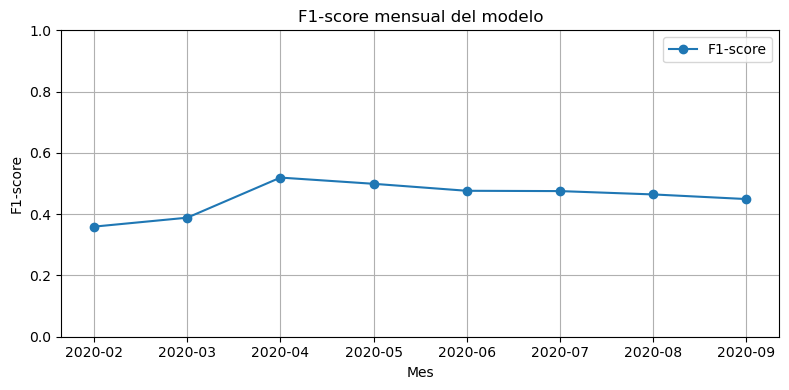

In [9]:
plot_f1_scores(df_eval)

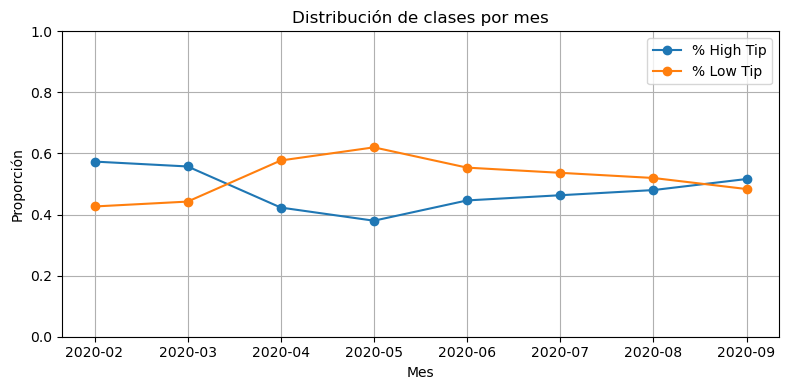

In [10]:
plot_class_distribution(df_eval)

## Analisis de resultados ##

Se observa que el F1-score comienza bajo en febrero (app. 0.36) y marzo (app. 0.39), aumenta significativamente en abril (app. 0.52), y luego disminuye levemente de mayo a septiembre (app. 0.50 a app. 0.45). 
El mejor rendimiento se observa en abril, lo que coincide con una disminución brusca en la proporción de propinas altas (de app. 57% en febrero a app. 42% en abril). Esto sugiere que el modelo funciona mejor cuando las clases están más balanceadas.
A partir de mayo, el rendimiento se estabiliza con una ligera tendencia a la baja, mientras que la proporcion de clases comienza a subir nuevamente hacia septiembre.
En septiembre se muestra un aumento en la proporción de propinas altas (app. 52%), pero el F1-score continúa disminuyendo. Esto sugiere que el modelo, entrenado solo con datos de enero, no se adapta bien a los cambios en el comportamiento de los pasajeros, por lo que su rendimiento empeora cuando las condiciones cambian.
En general, el desempeño del modelo es sensible a cambios en el equilibrio de clases y al contexto temporal (confinamientos por pandemia, menor volumen de viajes, etc.).

El modelo no mantiene un redimiento consistente, presenta variaciones claras en el F1-score a lo largo de los meses. Tiene bajo rendimiento en febrero y marzo, un alza marcada en abril, y una estabilización con ligera decadencia en los meses siguientes, esto refleja una fuerte dependencia del modelo al contexto temporal y a la distribución de los datos.

La variacion de desempeno se podria explicar por:
- Un posible sobreajuste al mes de enero, al haber entrenado el modelo con un único mes sin representar bien la variabilidad del año.
- Cambios en la proporción de clases (más o menos viajes con propina alta).
- Cambios en el comportamiento de los pasajeros debido a la pandemia: reducción de viajes, cambios en la propina, perfil de pasajeros distinto, etc.

Para mejorar la robustez del modelo en el tiempo, se podría considerar entrenarlo utilizando datos de múltiples meses en lugar de un solo mes. Además, implementar un esquema de reentrenamiento periódico (por ejemple, mensual o trimestral) permitiría al modelo adaptarse a cambios graduales en el comportamiento de los usuarios. Otra estrategia sería ajustar dinámicamente el umbral de clasificación si se detectan variaciones importantes en la proporción de clases. Finalmente, incorporar variables contextuales adicionales, como feriados, condiciones climáticas o restricciones sanitarias, podría ayudar al modelo a capturar mejor la realidad cambiante y mantener un rendimiento consistente a lo largo del tiempo.